# Tutorial: Cell Development Trajectory Inference
In this tutorial, we'll use BRICK to interpret cell development trajectory.

In [2]:
import sys
import os
#os.chdir("") # your working path
#sys.path.append("/BRICK/")
os.chdir("/Users/shang/Desktop/华大/") # your working path
sys.path.append("/Users/shang/Desktop/华大/BRICK/")

import scanpy as sc
from scipy.sparse.csgraph import connected_components
import numpy as np
import scipy.sparse
import pandas as pd
import re
import networkx as nx

import BRICK

## Configure your LLM

In [3]:
llm_url = "http://XXX.X.X.X:XXXXX" # your LLM url 
llm_params = {
        "model_name": {
        "service_provider": "azure",
        "tpm": 110000,
        "rpm": 660,
        "max_tokens": 32768 * 4,
        "token_per_transaction": 8191,
        "area": "美国中南部",
        "params": {
            "openai_api_base": "", # can be other model api
                    "openai_api_type": "azure",
                    "openai_api_version": "2023-07-01-preview",
                    "openai_api_key": "", # your api key
                    "model_name": "gpt-4-32k",
                    "deployment_name": "depl-gpt4-32k",
                    "temperature": 0.7, 
                    "max_tokens": 5000,
                    "request_timeout": 3000,
                    "max_retries": 5,
                    "openai_proxy": "",
                    "tiktoken_model_name": "gpt-4"
            },
        }
}

gpt_4o = "http://127.0.0.1:62140"
gpt_4o_params = {
    "gpt-4o": {
    "service_provider": "azure",
    "tpm": 110000,
    "rpm": 660,
    "max_tokens": 32768 * 4,
    "token_per_transaction": 8191,
    "area": "美国中南部",
    "llm_params": {
                "openai_api_base": "https://rhx3zc5jd3mps.openai.azure.com",
                "openai_api_type": "azure",
                "openai_api_version": "2023-07-01-preview",
                "model_name": "gpt-4o",
                "deployment_name": "depl-gpt4o",
                "openai_api_key": "7c8bf41e5bf44e3786fd0553415563db",
                "temperature": 0.7, 
                "max_tokens": 4096,
                "request_timeout": 3000,
                "max_retries": 5,
                "streaming": False,
                "openai_proxy": "",
                "tiktoken_model_name": "gpt-3.5-turbo", #gpt-4
                "callbacks": None
            },
        }
}

#BRICK.config_llm(llm_url, llm_params)

BRICK.config_llm(gpt_4o, gpt_4o_params)

/Users/shang/Desktop/华大/BRICK/_settings.py:59: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import AzureChatOpenAI``.
  _llm_instance = AzureChatOpenAI(**llm_params[first_key]["llm_params"])


LLM gpt-4o has been configured and initialized successfully.


/Users/shang/miniconda3/envs/brick/lib/python3.10/site-packages/langchain_community/chat_models/azure_openai.py:174: UserWarning: As of openai>=1.0.0, Azure endpoints should be specified via the `azure_endpoint` param not `openai_api_base` (or alias `base_url`). Updating `openai_api_base` from https://rhx3zc5jd3mps.openai.azure.com to https://rhx3zc5jd3mps.openai.azure.com/openai.
  warnings.warn(
/Users/shang/miniconda3/envs/brick/lib/python3.10/site-packages/langchain_community/chat_models/azure_openai.py:181: UserWarning: As of openai>=1.0.0, if `deployment_name` (or alias `azure_deployment`) is specified then `openai_api_base` (or alias `base_url`) should not be. Instead use `deployment_name` (or alias `azure_deployment`) and `azure_endpoint`.
  warnings.warn(
/Users/shang/miniconda3/envs/brick/lib/python3.10/site-packages/langchain_community/chat_models/azure_openai.py:189: UserWarning: As of openai>=1.0.0, if `openai_api_base` (or alias `base_url`) is specified it is expected to 

## Configure your Knowledge Graph

In [4]:
#url = ""
#auth = ("user_name", "password")  

url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)

## Calculate Cell Development Trajectory
Here we use scanpy.tl.paga() to obtain our cell development trajectory. \
We have preprocessed our Anndata by following the scanpy tutorial.

In [5]:
adata = sc.read_h5ad("/Users/shang/Desktop/华大/trajectory/data.nosync/processed_wbc_m.h5ad") # you can use your Anndata
adata

AnnData object with n_obs × n_vars = 30135 × 2000
    obs: 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'author_experimental_id', 'author_day', 'author_somite_count', 'author_major_cell_cluster', 'author_cell_type', 'tissue_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes', 'leiden'
    var: 'gene_short_name', 'chr', 'start', 'end', 'strand', 'gene_type', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'author_day_colors', 'author_somite_count_colors', 'citation', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'sch

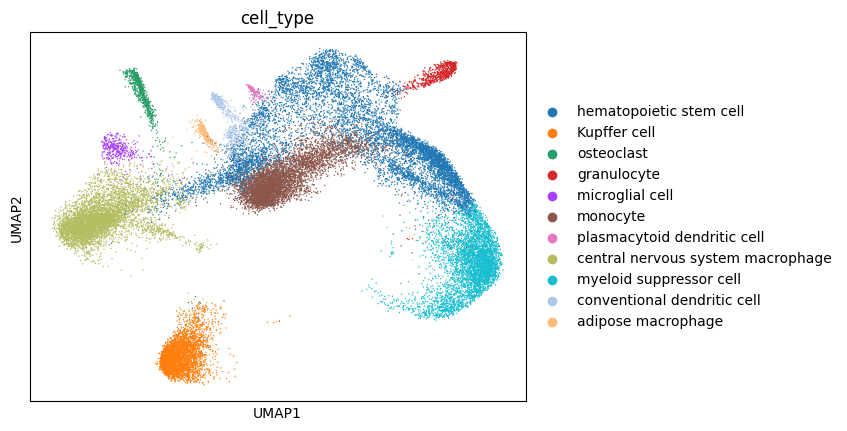

In [6]:
sc.pl.umap(adata,color="cell_type")

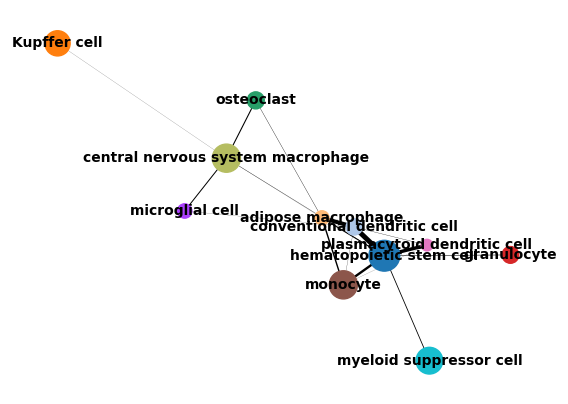

In [7]:
sc.tl.paga(adata, groups='cell_type')
sc.pl.paga(adata, frameon=False)

## Optional: ask LLM for your next step

In [7]:
question = "What should I do in next step with this adata after running paga."
result = BRICK.inp.paga_adviser(adata, question)
print("Generated Answer:", result)

Now generating answer ... 

Generated Answer: Based on the provided data and the connectivities matrix from your AnnData object, it's evident that you are examining the cell development trajectory graph using PAGA (Partition-based Graph Abstraction). The connectivities data in `adata.uns['paga']['connectivities_tree']` indicates the strength of connections between different cell groups.

### Analysis of Connectivities Data
- The connectivities data reveals the strength of connections between various cell clusters. For example, cluster 0 has notable connections with clusters 3, 5, 6, 8, and 9, with the highest connectivity value being 0.4766078908921259 between clusters 0 and 9.
- Some clusters have very weak or no connections, such as clusters 1 and 7, which have a low connectivity value of 0.012823112654292269.

### Suggestions:
1. **Grouping and Biological Interpretation:**
   - To make sense of the cell development trajectory, you should consider grouping the cells based on the conn

现在生成答案…

生成的答案：基于提供的数据和来自AnnData对象的连接矩阵，很明显您正在使用PAGA（基于分区的图抽象）检查细胞发展轨迹图。数据中的连接性数据。Uns ['paga']['connectivities_tree‘] ’表示不同细胞组之间的连接强度。

连接性数据分析
-连接数据揭示了不同细胞簇之间的连接强度。例如，集群0与集群3、5、6、8、9之间存在显著的连接，集群0与集群9之间的连接值最高，为0.4766078908921259。
—部分集群连接非常弱或没有连接，例如集群1和集群7，连接值较低，为0.012823112654292269。

# # #建议:
1. **分组和生物学解释：**
-为了理解细胞的发展轨迹，您应该考虑根据连接值对细胞进行分组。分组应具有生物学意义，反映细胞发育的不同阶段或类型。
—为连接值设置阈值，以确定哪些连接足够强，可以认为是重要的。这个阈值将帮助你过滤掉噪音，专注于最相关的联系。

2. * *的阈值设置:* *
—根据连通性数据，0.05的阈值似乎是合理的。这个值允许你在排除较弱的、可能不太相关的连接的同时，包括那些足够强大的、具有生物学意义的连接。

生物学原理：
-设置阈值可以识别不同的细胞群，这些细胞群更有可能代表细胞发育的不同阶段或类型。例如，连接值高于0.05可能表明显著的发展关系，而较低的值可能表示噪声或弱相互作用。
—通过基于该阈值对细胞进行分组，可以更好地了解细胞发育轨迹中的过渡和分支点。

###下一步：
1. **设置连接阈值：**
—使用0.05的阈值来过滤数据中的连通性值。”(“paga”)(“connectivities_tree”)的矩阵。
-结果组将代表具有重要发育关系的细胞群。

2. **可视化PAGA图：**
—阈值设置完成后，PAGA图形可视化，显示细胞发育轨迹。此可视化将帮助您确定单元格开发过程中的关键过渡点和分支事件。

3. **解释生物学意义：**
-分析应用阈值后形成的群体，了解其生物学意义。观察细胞类型、发育阶段和其他相关元数据，以深入了解发育轨迹。

4. 进一步分析:* * * *
-进行下游分析，如差异基因表达，以识别与特定发育转变相关的基因。
-使用鉴定的组来指导进一步的实验或验证，如功能分析或谱系追踪研究。

通过遵循这些步骤，您将能够将数据分成有意义的组，并深入了解细胞发育轨迹。为你的连接设置一个0.05的阈值将帮助你过滤掉噪音，专注于生物相关的连接。

In [26]:
connectivities = adata.uns['paga']['connectivities_tree'].toarray()
print(connectivities)

[[0.         0.         0.         0.05060649 0.         0.22518387
  0.32909885 0.         0.07881067 0.47660789 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.01282311 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.10393856 0.         0.         0.0330186 ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.09635173 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.

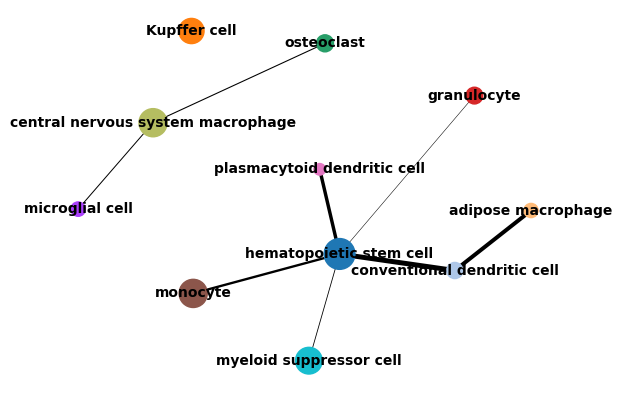

In [6]:
sc.pl.paga(adata, solid_edges='connectivities_tree', threshold=0.05, frameon=False)

## Split whole adata into 3 subgroups
We'll use group 0 to do future analysis.

In [17]:
connectivities = adata.uns['paga']['connectivities_tree'].toarray()

threshold = 0.05
connectivities[connectivities < threshold] = 0

n_clusters, labels = connected_components(connectivities)

cell_type_to_cluster = dict(zip(adata.obs['cell_type'].cat.categories, labels))

adata.obs['paga_cluster'] = adata.obs['cell_type'].map(cell_type_to_cluster)

valid_clusters = set(cell_type_to_cluster.values())
adata = adata[adata.obs['paga_cluster'].isin(valid_clusters)].copy()

adata.obs['cell_type'] = adata.obs['cell_type'].cat.remove_unused_categories()

adata_clusters = {}

for cluster_id in range(n_clusters):
    if cluster_id not in valid_clusters:
        continue
    
    adata_cluster = adata[adata.obs['paga_cluster'] == cluster_id].copy()

    categories = adata_cluster.obs['cell_type'].cat.categories
    connectivities_cluster = adata.uns['paga']['connectivities_tree'].toarray()
    indices = [i for i, cat in enumerate(adata.obs['cell_type'].cat.categories) if cat in categories]

    connectivities_cluster = connectivities_cluster[np.ix_(indices, indices)]

    connectivities_df = pd.DataFrame(connectivities_cluster, index=categories, columns=categories)

    adata_cluster.uns['paga']['connectivities_tree'] = scipy.sparse.csr_matrix(connectivities_df.values)
    adata_cluster.uns['paga']['connectivities_df'] = connectivities_df

    adata_cluster.obs['cell_type'] = adata_cluster.obs['cell_type'].cat.remove_unused_categories()

    adata_clusters[cluster_id] = adata_cluster

adata_0 = adata_clusters[0]

In [18]:
adata_0

AnnData object with n_obs × n_vars = 19869 × 2000
    obs: 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'author_experimental_id', 'author_day', 'author_somite_count', 'author_major_cell_cluster', 'author_cell_type', 'tissue_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes', 'leiden', 'paga_cluster'
    var: 'gene_short_name', 'chr', 'start', 'end', 'strand', 'gene_type', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'author_day_colors', 'author_somite_count_colors', 'citation', 'hvg', 'leiden', 'log1p', 'neighbo

/Users/shang/miniconda3/envs/brick/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


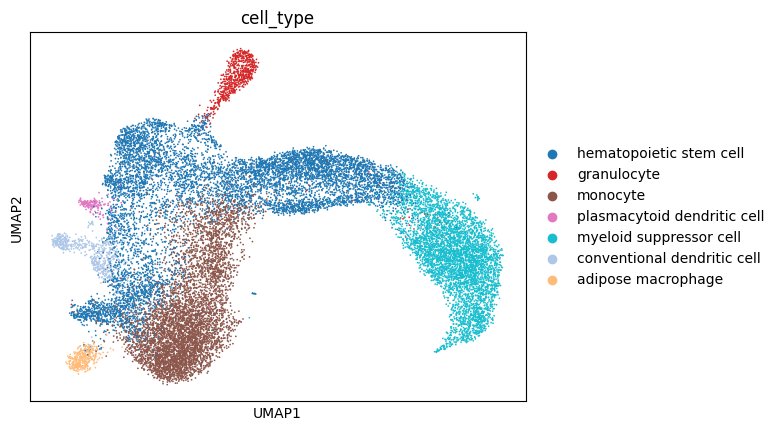

In [21]:
sc.pp.neighbors(adata_0)
sc.pp.pca(adata_0)
sc.tl.umap(adata_0)
sc.pl.umap(adata_0,color="cell_type")

## Visualize data in PAGA pseudotime

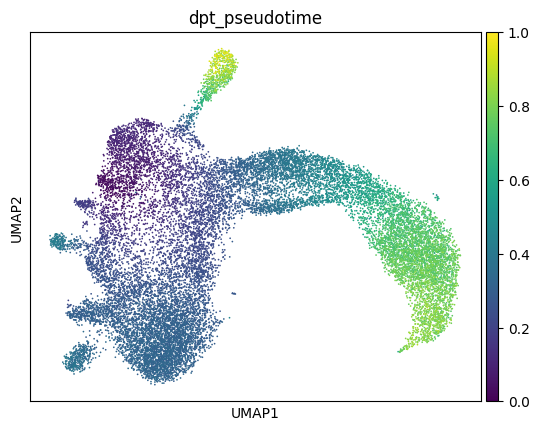

In [22]:
adata_0.uns['iroot'] = np.flatnonzero(adata_0.obs['cell_type'] == 'hematopoietic stem cell')[0]
sc.tl.dpt(adata_0)
sc.pl.umap(adata_0,color=["dpt_pseudotime"])

## Visualize your paga trajectory by BRICK.pp.paga2nx
You can use different functions to visualize your graph and save it in various formats. \
Here we show an example of static graph, all paths calculated by paga are considered unverified.

Graph saved to ./paga.svg


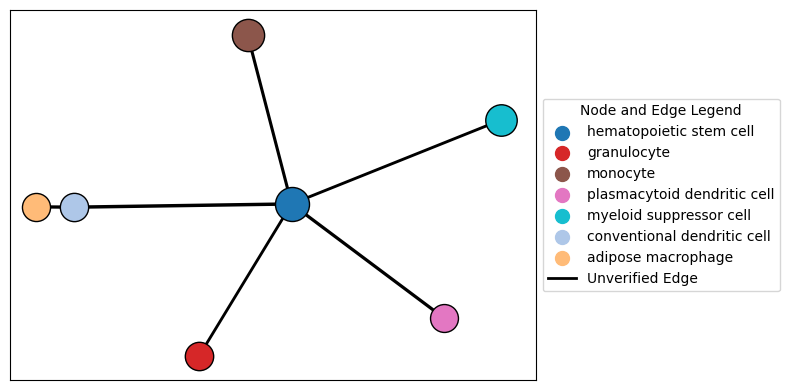

In [11]:
G = BRICK.pp.paga2nx(adata_0)
#BRICK.pl.interact_visualize_network(G, node_label = 'original_name',notebook=False, save="./paga.html")
BRICK.pl.static_visualize_network(G, save_path="./paga.svg")
#BRICK.pp.save_graph(G,"./paga2.svg")

## Specific steps to search nodes
Here we use specific functions to search all paga nodes in our knowledge graph, you can use you own function.

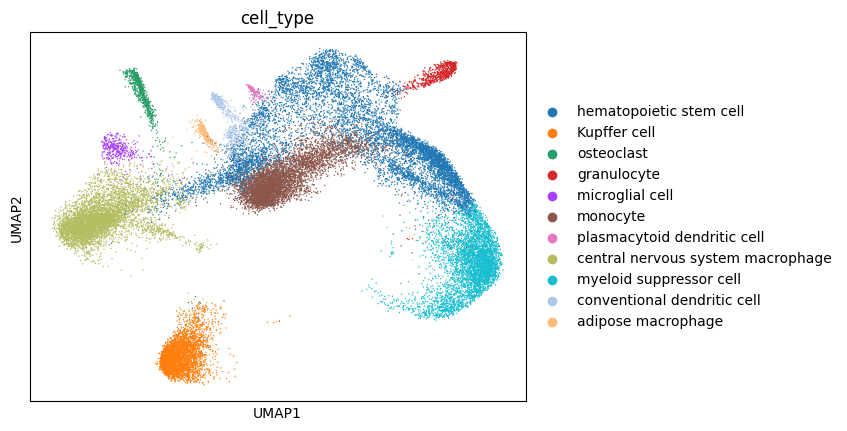

In [17]:
sc.tl.paga(adata, groups='cell_type')
sc.pl.umap(adata,color="cell_type")

In [8]:
connectivities = adata.uns['paga']['connectivities_tree'].toarray()

threshold = 0.05
connectivities[connectivities < threshold] = 0

n_clusters, labels = connected_components(connectivities)

cell_type_to_cluster = dict(zip(adata.obs['cell_type'].cat.categories, labels))

adata.obs['paga_cluster'] = adata.obs['cell_type'].map(cell_type_to_cluster)

valid_clusters = set(cell_type_to_cluster.values())
adata = adata[adata.obs['paga_cluster'].isin(valid_clusters)].copy()

adata.obs['cell_type'] = adata.obs['cell_type'].cat.remove_unused_categories()

adata_clusters = {}

for cluster_id in range(n_clusters):
    if cluster_id not in valid_clusters:
        continue
    
    adata_cluster = adata[adata.obs['paga_cluster'] == cluster_id].copy()

    categories = adata_cluster.obs['cell_type'].cat.categories
    connectivities_cluster = adata.uns['paga']['connectivities_tree'].toarray()
    indices = [i for i, cat in enumerate(adata.obs['cell_type'].cat.categories) if cat in categories]

    connectivities_cluster = connectivities_cluster[np.ix_(indices, indices)]

    connectivities_df = pd.DataFrame(connectivities_cluster, index=categories, columns=categories)

    adata_cluster.uns['paga']['connectivities_tree'] = scipy.sparse.csr_matrix(connectivities_df.values)
    adata_cluster.uns['paga']['connectivities_df'] = connectivities_df

    adata_cluster.obs['cell_type'] = adata_cluster.obs['cell_type'].cat.remove_unused_categories()

    adata_clusters[cluster_id] = adata_cluster

adata_0 = adata_clusters[0]

In [9]:
sc.pp.neighbors(adata_0)
sc.pp.pca(adata_0)
sc.tl.umap(adata_0)

/Users/shang/miniconda3/envs/brick/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


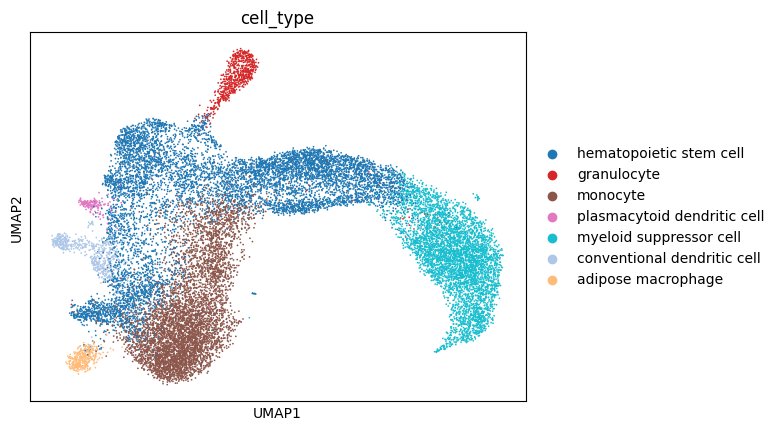

In [10]:
sc.pl.umap(adata_0,color="cell_type")

优化3

In [93]:
G = BRICK.pp.paga2nx(adata_0)
edge_pairs = list(G.edges())  # G 中的边
original_nodes = list(G.nodes())  # G 中的节点

nx_new_paga = nx.MultiDiGraph() 

#添加 G 中的所有节点，并保留其属性
for node, data in G.nodes(data=True):
    nx_new_paga.add_node(node, **data)

paths_dict = {}
all_nodes = set()
rel_list = []

for node in edge_pairs:
    qn = BRICK.qr.query_shortest_path(source_entity_name=node[0],target_entity_name=node[1], source_entity_type="Cell",target_entity_type="Cell",relation="is_a|develope_into",multi_hop=(1,10),return_type='dataframe')

    for _, row in qn.iterrows():
        nodes = [row[f'path.{i}.name'] for i in range(9) if pd.notna(row.get(f'path.{i}.name'))]
        relations = [row[f'path.{i}.relation'] for i in range(1, 9) if pd.notna(row.get(f'path.{i}.relation'))]
        
        all_nodes.update(nodes)
        rel_list.extend(zip(nodes[:-1], nodes[1:], relations))

    # 构建 stem cell 节点映射
    stem_cell_to_cell_map = {
        re.sub(r' stem cell$', ' cell', node): node for node in all_nodes if "stem cell" in node
    }

    # 更新节点和关系信息
    modified_node_list = []
    updated_rel_list = []

    for start_node, end_node, relation in rel_list:
        start_name = stem_cell_to_cell_map.get(start_node, start_node)
        end_name = stem_cell_to_cell_map.get(end_node, end_node)

        if relation == "is_a" and start_name != end_name:
            modified_node_list.append((end_name, start_name))
        else:
            if start_name != end_name:
                modified_node_list.append((start_name, end_name))
        
        updated_rel_list.append((start_name, end_name, relation))

    # 去重处理，确保节点对与路径的唯一性
    merged_node_list = list({node_pair for node_pair in modified_node_list if node_pair[0] != node_pair[1]})

    # 构建 paths_dict
    path_key = tuple(merged_node_list)
    if path_key not in paths_dict:
        paths_dict[path_key] = {"relationships": [], "direction": "mixed"}

    for start, end, rela_type in updated_rel_list:
        paths_dict[path_key]["relationships"].append(rela_type)


paga_graph = G
nx_filtered_paga = nx.MultiDiGraph() 

# 提取 PAGA 图中的节点和边
nodes_in_paga = set(paga_graph.nodes())
original_edges_in_paga = set(paga_graph.edges())

# Step 1: 构建查询返回的图 (nx_new_paga)
for path_key, path_data in paths_dict.items():
    for start_node, end_node in path_key:
        if start_node in nodes_in_paga or end_node in nodes_in_paga:
            #relation_info = path_data["relationships"]
            relation_info = ", ".join(path_data["relationships"])  # 将列表转换成字符串

            direction = path_data.get("direction", "mixed")

            # 确保节点存在
            nx_new_paga.add_node(start_node)
            nx_new_paga.add_node(end_node)

            # 添加带方向的边
            if direction == "forward":
                nx_new_paga.add_edge(start_node, end_node, relation=relation_info)
            elif direction == "backward":
                nx_new_paga.add_edge(end_node, start_node, relation=relation_info)
            else:
                nx_new_paga.add_edge(start_node, end_node, relation=relation_info)
                nx_new_paga.add_edge(end_node, start_node, relation=relation_info)  # 双向

# Step 2: 计算 PAGA 图节点对的最短路径
valid_edges = set()
found_path_edges = set()

for start_node, end_node in original_edges_in_paga:
    if start_node != end_node:
        try:
            # 获取所有简单路径
            all_paths = list(nx.all_simple_paths(nx_new_paga, source=start_node, target=end_node))

            if all_paths:  # 至少存在一条路径
                # 找到最短路径（可能有多条相同最短长度的路径）
                min_length = min(len(path) for path in all_paths)  # 获取最短路径长度
                shortest_paths = [path for path in all_paths if len(path) == min_length]  # 选取所有最短路径
                
                for path in shortest_paths:
                    for i in range(len(path) - 1):
                        valid_edges.add((path[i], path[i + 1]))
                    found_path_edges.add((start_node, end_node))  # 标记已找到路径的 PAGA 边

        except nx.NetworkXNoPath:
            pass  # 无路径时跳过

# Step 3: 构建最终的 PAGA 过滤图 (nx_filtered_paga)
for node in nodes_in_paga:
    nx_filtered_paga.add_node(node, **paga_graph.nodes[node])  # 直接复制 PAGA 节点数据

# Step 4: 添加绿色路径
for edge in valid_edges:
    edge_data = nx_new_paga.get_edge_data(edge[0], edge[1], default={}) or {}  # 确保不是 None
    nx_filtered_paga.add_edge(edge[0], edge[1], color="green", weight=8, arrows = "to")

# Step 5: 添加红色无向边（PAGA 中原有但查询未找到路径的）
for source, target in original_edges_in_paga:
    if (source, target) not in found_path_edges and (target, source) not in found_path_edges:
        nx_filtered_paga.add_edge(source, target, color="red", weight=2, arrows=None)  # 无向边

# Step 6: 确保所有 PAGA 节点都保留
for node in nodes_in_paga:
    if node not in nx_filtered_paga:
        nx_filtered_paga.add_node(node, **paga_graph.nodes[node])


BRICK.pp.save_graph(nx_filtered_paga,"/Users/shang/Desktop/华大/t4.svg")

TypeError: unhashable type: 'dict'

In [88]:
qn = BRICK.qr.query_path(node,target_entity_set=node,relation=["is_a|develope_into"],multi_hop=(1,4),source_entity_type="Cell",target_entity_type="Cell",query_attribution="name",link=1,directed=True)
print(qn)

                                          path.0.def   path.0.id  \
0  A leukocyte with abundant granules in the cyto...  CL:0000094   
1  A leukocyte with abundant granules in the cyto...  CL:0000094   
2  Myeloid mononuclear recirculating leukocyte th...  CL:0000576   
3  An immature myeloid leukocyte of heterogeneous...  CL:0000889   
4  Myeloid mononuclear recirculating leukocyte th...  CL:0000576   
5  A leukocyte with abundant granules in the cyto...  CL:0000094   
6  A leukocyte with abundant granules in the cyto...  CL:0000094   
7  Myeloid mononuclear recirculating leukocyte th...  CL:0000576   
8  An immature myeloid leukocyte of heterogeneous...  CL:0000889   

               path.0.name                                     path.0.synonym  \
0              granulocyte  granular leucocyte|granular leukocyte|polymorp...   
1              granulocyte  granular leucocyte|granular leukocyte|polymorp...   
2                 monocyte                                              Unde

In [89]:
columns_to_keep = [col for col in qn.columns if any(col.endswith(suffix) for suffix in [".name", ".type", ".relation"])]

fqn = qn[columns_to_keep]

In [90]:
columns_name = [col for col in qn.columns if col.endswith(".name")]
columns_type = [col for col in qn.columns if col.endswith(".type")]
columns_relation = [col for col in qn.columns if col.endswith(".relation")]

# 仅保留所需列
fqn = qn[columns_name + columns_type + columns_relation]

print(fqn)

               path.0.name                      path.2.name  \
0              granulocyte                     myeloid cell   
1              granulocyte                myeloid leukocyte   
2                 monocyte                myeloid leukocyte   
3  myeloid suppressor cell                myeloid leukocyte   
4                 monocyte  monocyte-derived dendritic cell   
5              granulocyte                     myeloid cell   
6              granulocyte                myeloid leukocyte   
7                 monocyte                myeloid leukocyte   
8  myeloid suppressor cell                myeloid leukocyte   

              path.4.name                  path.6.name  \
0  myeloid dendritic cell  conventional dendritic cell   
1            myeloid cell       myeloid dendritic cell   
2            myeloid cell       myeloid dendritic cell   
3            myeloid cell       myeloid dendritic cell   
4  myeloid dendritic cell  conventional dendritic cell   
5         Langerhans 

In [91]:
paths = []

for _, row in fqn.iterrows():
    # 过滤出 "Cell" 类型的节点索引
    cell_indices = [i for i, col in enumerate(columns_type) if row[col] == "Cell"]

    # 需要至少两个 "Cell" 才能构成路径
    if len(cell_indices) < 2:
        continue

    # 逐步构建 (头节点, 关系, 尾节点)
    for j in range(len(cell_indices) - 1):
        start_idx = cell_indices[j]
        end_idx = cell_indices[j + 1]

        # 获取头节点、尾节点、关系
        start_node = row[columns_name[start_idx]]
        end_node = row[columns_name[end_idx]]
        relation = row[columns_relation[start_idx]]

        # 确保所有数据都有效
        if pd.notna(start_node) and pd.notna(end_node) and pd.notna(relation):
            if (start_node, relation, end_node) not in paths:
                paths.append((start_node, relation, end_node))

print(paths)

[('granulocyte', 'is_a', 'myeloid cell'), ('myeloid cell', 'develope_into', 'myeloid dendritic cell'), ('myeloid dendritic cell', 'is_a', 'conventional dendritic cell'), ('granulocyte', 'is_a', 'myeloid leukocyte'), ('myeloid leukocyte', 'is_a', 'myeloid cell'), ('monocyte', 'is_a', 'myeloid leukocyte'), ('myeloid suppressor cell', 'is_a', 'myeloid leukocyte'), ('monocyte', 'develope_into', 'monocyte-derived dendritic cell'), ('monocyte-derived dendritic cell', 'is_a', 'myeloid dendritic cell'), ('myeloid cell', 'develope_into', 'Langerhans cell'), ('Langerhans cell', 'is_a', 'conventional dendritic cell')]


In [39]:
paths_dict = {}
all_nodes = set()
rel_list = []

# 遍历提取节点及关系信息
for _, row in qn.iterrows():
    nodes = [row[f'path.{i}.name'] for i in range(9) if pd.notna(row.get(f'path.{i}.name'))]
    relations = [row[f'path.{i}.relation'] for i in range(1, 9) if pd.notna(row.get(f'path.{i}.relation'))]
    
    all_nodes.update(nodes)
    rel_list.extend(zip(nodes[:-1], nodes[1:], relations))

# 构建 stem cell 节点映射
stem_cell_to_cell_map = {
    re.sub(r' stem cell$', ' cell', node): node for node in all_nodes if "stem cell" in node
}

# 更新节点和关系信息
modified_node_list = []
updated_rel_list = []

for start_node, end_node, relation in rel_list:
    start_name = stem_cell_to_cell_map.get(start_node, start_node)
    end_name = stem_cell_to_cell_map.get(end_node, end_node)

    if relation == "is_a" and start_name != end_name:
        modified_node_list.append((end_name, start_name))
    else:
        if start_name != end_name:
            modified_node_list.append((start_name, end_name))
    
    updated_rel_list.append((start_name, end_name, relation))

# 去重处理，确保节点对与路径的唯一性
merged_node_list = list({node_pair for node_pair in modified_node_list if node_pair[0] != node_pair[1]})

# 构建 paths_dict
path_key = tuple(merged_node_list)
if path_key not in paths_dict:
    paths_dict[path_key] = {"relationships": [], "direction": "mixed"}

for start, end, rela_type in updated_rel_list:
    paths_dict[path_key]["relationships"].append(rela_type)

paths_dict

{(('pre-conventional dendritic cell', 'CD103-positive dendritic cell'),
  ('mesoderm-derived structure', 'macrophage dendritic cell progenitor'),
  ('CD103-positive dendritic cell', 'conventional dendritic cell'),
  ('monocyte-derived dendritic cell', 'monocyte'),
  ('hematopoietic stem cell', 'progenitor cell'),
  ('mature conventional dendritic cell',
   'mature CD8_alpha-positive CD11b-negative dendritic cell'),
  ('CD115-positive monocyte', 'myeloid lineage restricted progenitor cell'),
  ('angioblastic mesenchymal cell', 'hematopoietic stem cell'),
  ('blood cell', 'hematopoietic stem cell'),
  ('mononuclear cell of umbilical cord', 'mesoderm-derived structure'),
  ('mature CD8_alpha-negative CD11b-negative dendritic cell',
   'CD8_alpha-negative CD11b-negative dendritic cell'),
  ('CD14-positive monocyte',
   'CD14-positive, CD16-negative classical monocyte'),
  ('thymic plasmacytoid dendritic cell', 'DN1 thymic pro-T cell'),
  ('immature CD11c-low plasmacytoid dendritic cell',
 

In [52]:
# 初始化
paga_graph = G
nx_new_paga = nx.DiGraph()
nx_filtered_paga = nx.MultiDiGraph() 

# 提取 PAGA 图中的节点和边
nodes_in_paga = set(paga_graph.nodes())
original_edges_in_paga = set(paga_graph.edges())

# Step 1: 构建查询返回的图 (nx_new_paga)
for path_key, path_data in paths_dict.items():
    for start_node, end_node in path_key:
        if start_node in nodes_in_paga or end_node in nodes_in_paga:
            #relation_info = path_data["relationships"]
            relation_info = ", ".join(path_data["relationships"])  # 将列表转换成字符串

            direction = path_data.get("direction", "mixed")

            # 确保节点存在
            nx_new_paga.add_node(start_node)
            nx_new_paga.add_node(end_node)

            # 添加带方向的边
            if direction == "forward":
                nx_new_paga.add_edge(start_node, end_node, relation=relation_info)
            elif direction == "backward":
                nx_new_paga.add_edge(end_node, start_node, relation=relation_info)
            else:
                nx_new_paga.add_edge(start_node, end_node, relation=relation_info)
                nx_new_paga.add_edge(end_node, start_node, relation=relation_info)  # 双向

# Step 2: 计算 PAGA 图节点对的最短路径
valid_edges = set()
found_path_edges = set()

for start_node, end_node in original_edges_in_paga:
    if start_node != end_node:
        try:
            # 获取所有简单路径
            all_paths = list(nx.all_simple_paths(nx_new_paga, source=start_node, target=end_node))

            if all_paths:  # 至少存在一条路径
                # 找到最短路径（可能有多条相同最短长度的路径）
                min_length = min(len(path) for path in all_paths)  # 获取最短路径长度
                shortest_paths = [path for path in all_paths if len(path) == min_length]  # 选取所有最短路径
                
                for path in shortest_paths:
                    for i in range(len(path) - 1):
                        valid_edges.add((path[i], path[i + 1]))
                    found_path_edges.add((start_node, end_node))  # 标记已找到路径的 PAGA 边

        except nx.NetworkXNoPath:
            pass  # 无路径时跳过

# Step 3: 构建最终的 PAGA 过滤图 (nx_filtered_paga)
for node in nodes_in_paga:
    nx_filtered_paga.add_node(node, **paga_graph.nodes[node])  # 直接复制 PAGA 节点数据

# Step 4: 添加绿色路径
for edge in valid_edges:
    edge_data = nx_new_paga.get_edge_data(edge[0], edge[1], default={}) or {}  # 确保不是 None
    edge_data.update({"color": "green", "weight": 8, "arrows": "to"})  # 设置默认属性
    nx_filtered_paga.add_edge(edge[0], edge[1], **edge_data)

# Step 5: 添加红色无向边（PAGA 中原有但查询未找到路径的）
for source, target in original_edges_in_paga:
    if (source, target) not in found_path_edges and (target, source) not in found_path_edges:
        nx_filtered_paga.add_edge(source, target, color="red", weight=2)  # 无向边

# Step 6: 确保所有 PAGA 节点都保留
for node in nodes_in_paga:
    if node not in nx_filtered_paga:
        nx_filtered_paga.add_node(node, **paga_graph.nodes[node])


In [53]:
BRICK.pp.save_graph(nx_filtered_paga,"/Users/shang/Desktop/华大/nx_filtered_paga5.svg")

Graph successfully saved to /Users/shang/Desktop/华大/nx_filtered_paga5.svg.svg


测试

In [64]:
print(original_nodes)

{'conventional dendritic cell', 'granulocyte', 'plasmacytoid dendritic cell', 'hematopoietic stem cell', 'monocyte', 'adipose macrophage', 'myeloid suppressor cell'}


In [65]:
qn = BRICK.qr.query_shortest_path(source_entity_name='hematopoietic stem cell',target_entity_name="adipose macrophage", source_entity_type="Cell",target_entity_type="Cell",relation="is_a|develope_into",multi_hop=(1,10),return_type='dataframe')
print(qn)

                                          path.0.def   path.0.id  \
0  A stem cell from which all cells of the lympho...  CL:0000037   

               path.0.name                                     path.0.synonym  \
0  hematopoietic stem cell  blood forming stem cell|colony forming unit he...   

  path.0.type path.1 path.1.condition path.1.info_source  \
0        Cell   is_a   [Undef, Undef]      [UBERON, EFO]   

   path.1.info_source_length path.1.original_relation  ...   path.8.id  \
0                          2             [is_a, is_a]  ...  CL:0000864   

                  path.8.name                       path.8.synonym  \
0  tissue-resident macrophage  fixed macrophage|resting histiocyte   

  path.8.type path.9       path.9.condition  \
0        Cell   is_a  [Undef, Undef, Undef]   

                          path.9.info_source path.9.info_source_length  \
0  [GO-PLUS, UPHENO_ALL_WITH_RELATIONS, EFO]                         3   

  path.9.original_relation path.9.relation  


In [73]:
columns_name = [col for col in qn.columns if col.endswith(".name")]
columns_type = [col for col in qn.columns if col.endswith(".type")]
columns_relation = [col for col in qn.columns if col.endswith(".relation")]

columns_name.sort(key=lambda col: int(col.split('.')[1]))
columns_type.sort(key=lambda col: int(col.split('.')[1]))
columns_relation.sort(key=lambda col: int(col.split('.')[1]))

# 仅保留所需列
fqn = qn[columns_name + columns_type + columns_relation]

print(fqn)

               path.0.name         path.2.name  \
0  hematopoietic stem cell  hematopoietic cell   

                      path.4.name             path.6.name  \
0  bone marrow hematopoietic cell  bone marrow macrophage   

                  path.8.name        path.10.name path.0.type path.2.type  \
0  tissue-resident macrophage  adipose macrophage        Cell        Cell   

  path.4.type path.6.type path.8.type path.10.type path.1.relation  \
0        Cell        Cell        Cell         Cell            is_a   

  path.3.relation path.5.relation path.7.relation path.9.relation  
0            is_a            is_a            is_a            is_a  


In [74]:
paths = []
for _, row in fqn.iterrows():
    # 过滤出 "Cell" 类型的节点索引
    cell_indices = [i for i, col in enumerate(columns_type) if row[col] == "Cell"]

    # 需要至少两个 "Cell" 才能构成路径
    if len(cell_indices) < 2:
        continue

    # 逐步构建 (头节点, 关系, 尾节点)
    for j in range(len(cell_indices) - 1):
        start_idx = cell_indices[j]
        end_idx = cell_indices[j + 1]

        # 获取头节点、尾节点、关系
        start_node = row[columns_name[start_idx]]
        end_node = row[columns_name[end_idx]]
        relation = row[columns_relation[start_idx]]

        # 确保所有数据都有效
        if pd.notna(start_node) and pd.notna(end_node) and pd.notna(relation):
            if (start_node, relation, end_node) not in paths:
                paths.append((start_node, relation, end_node))
print(paths)

[('hematopoietic stem cell', 'is_a', 'hematopoietic cell'), ('hematopoietic cell', 'is_a', 'bone marrow hematopoietic cell'), ('bone marrow hematopoietic cell', 'is_a', 'bone marrow macrophage'), ('bone marrow macrophage', 'is_a', 'tissue-resident macrophage'), ('tissue-resident macrophage', 'is_a', 'adipose macrophage')]


In [78]:
nx_new_paga = nx.MultiDiGraph()

#提取原始 PAGA 图的节点和边
edge_pairs = list(G.edges())  # G 中的边
original_nodes = set(G.nodes())  # G 中的节点

#添加 G 中的所有节点，并保留其属性
for node, data in G.nodes(data=True):
    nx_new_paga.add_node(node, **data)

all_paths = []

for node in edge_pairs:
    print(node[0],node[1])
    qn = BRICK.qr.query_shortest_path(source_entity_name=node[0],target_entity_name=node[1], source_entity_type="Cell",target_entity_type="Cell",relation="is_a|develope_into",multi_hop=(1,10),return_type='dataframe')

    columns_name = [col for col in qn.columns if col.endswith(".name")]
    columns_type = [col for col in qn.columns if col.endswith(".type")]
    columns_relation = [col for col in qn.columns if col.endswith(".relation")]

    columns_name.sort(key=lambda col: int(col.split('.')[1]))
    columns_type.sort(key=lambda col: int(col.split('.')[1]))
    columns_relation.sort(key=lambda col: int(col.split('.')[1]))

    # 仅保留所需列
    fqn = qn[columns_name + columns_type + columns_relation]
    #print(fqn)

    paths = []

    for _, row in fqn.iterrows():
        # 过滤出 "Cell" 类型的节点索引
        cell_indices = [i for i, col in enumerate(columns_type) if row[col] == "Cell"]

        # 需要至少两个 "Cell" 才能构成路径
        if len(cell_indices) < 2:
            continue

        # 逐步构建 (头节点, 关系, 尾节点)
        for j in range(len(cell_indices) - 1):
            start_idx = cell_indices[j]
            end_idx = cell_indices[j + 1]

            # 获取头节点、尾节点、关系
            start_node = row[columns_name[start_idx]]
            end_node = row[columns_name[end_idx]]
            relation = row[columns_relation[start_idx]]

            # 确保所有数据都有效
            if pd.notna(start_node) and pd.notna(end_node) and pd.notna(relation):
                if (start_node, relation, end_node) not in paths:
                    """ if relation == "is_a":
                        paths.append((end_node, relation, start_node))
                    else: """
                    paths.append((start_node, relation, end_node))

    all_paths.extend(paths)

#print(all_paths)

added_edges = set()
#处理 paths 数据，并添加缺失的节点
for source, relation, target in all_paths:
    # 确保 source 和 target 在图中
    if source not in nx_new_paga:
        nx_new_paga.add_node(source, color='gray', shape='hexagon', size=12)
    if target not in nx_new_paga:
        nx_new_paga.add_node(target, color='gray', shape='hexagon', size=12)

    if (source,target) not in added_edges:
        nx_new_paga.add_edge(source, target, color='green', weight=8, arrows='to')
        added_edges.add((source,target))

#添加红色边（即在 G 中有但未在 nx_new_paga 中连通的边）
for source, target in edge_pairs:
    # 只添加 nx_new_paga 中不连通的边（无论直接还是间接）
    if not (nx.has_path(nx_new_paga, source, target) or nx.has_path(nx_new_paga, target, source)):
        nx_new_paga.add_edge(source, target, color='red', weight=2, arrows='none')

#确保所有 PAGA 图的节点都保留
for node in original_nodes:
    if node not in nx_new_paga:
        nx_new_paga.add_node(node)  # 原始节点必须保留

final_G = nx_new_paga



hematopoietic stem cell granulocyte
hematopoietic stem cell monocyte
hematopoietic stem cell plasmacytoid dendritic cell
hematopoietic stem cell myeloid suppressor cell
hematopoietic stem cell conventional dendritic cell
conventional dendritic cell adipose macrophage


In [63]:
print(final_G.edges)

[('hematopoietic stem cell', 'leukocyte', 0), ('conventional dendritic cell', 'Langerhans cell', 0), ('leukocyte', 'myeloid leukocyte', 0), ('leukocyte', 'monocyte', 0), ('leukocyte', 'dendritic cell', 0), ('myeloid leukocyte', 'granulocyte', 0), ('myeloid leukocyte', 'myeloid suppressor cell', 0), ('dendritic cell', 'plasmacytoid dendritic cell', 0), ('dendritic cell', 'conventional dendritic cell', 0), ('Langerhans cell', 'macrophage', 0), ('macrophage', 'tissue-resident macrophage', 0), ('tissue-resident macrophage', 'adipose macrophage', 0)]


In [77]:
print(all_paths)

[('hematopoietic stem cell', 'develope_into', 'leukocyte'), ('leukocyte', 'is_a', 'myeloid leukocyte'), ('myeloid leukocyte', 'is_a', 'granulocyte'), ('hematopoietic stem cell', 'develope_into', 'leukocyte'), ('leukocyte', 'is_a', 'monocyte'), ('hematopoietic stem cell', 'develope_into', 'leukocyte'), ('leukocyte', 'is_a', 'dendritic cell'), ('dendritic cell', 'is_a', 'plasmacytoid dendritic cell'), ('hematopoietic stem cell', 'develope_into', 'leukocyte'), ('leukocyte', 'is_a', 'myeloid leukocyte'), ('myeloid leukocyte', 'is_a', 'myeloid suppressor cell'), ('hematopoietic stem cell', 'develope_into', 'leukocyte'), ('leukocyte', 'is_a', 'dendritic cell'), ('dendritic cell', 'is_a', 'conventional dendritic cell'), ('conventional dendritic cell', 'is_a', 'Langerhans cell'), ('Langerhans cell', 'is_a', 'macrophage'), ('macrophage', 'is_a', 'tissue-resident macrophage'), ('tissue-resident macrophage', 'is_a', 'adipose macrophage')]


In [76]:
BRICK.pp.save_graph(final_G,"./t3.svg")

Graph successfully saved to ./t3.svg.svg


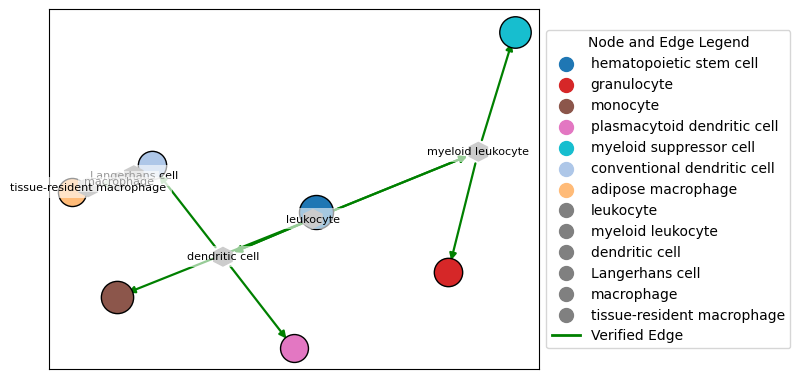

In [32]:
BRICK.pl.static_visualize_network(final_G, layout='spring')

原版

In [8]:
cypher_a = "MATCH path=(n:Cell)-[r:is_a|develope_into*1..4]-(m:Cell) WHERE n.name = $source AND m.name = $target RETURN DISTINCT path, nodes(path), relationships(path)"

def find_node(cypher, source, target):
    parameters = {'source': source, 'target': target}
    #print(parameters)
    result = BRICK.qr.query_cypher(cypher, parameters, 'list')
    #print(result)

    paths_dict = {}
    all_nodes = set() 

    rel_list = []
    for record in result:
        #print("r: ",record)
        rel_list += record["relationships(path)"]
        for rela in record["relationships(path)"]:
            all_nodes.update([rela.nodes[0]["name"], rela.nodes[1]["name"]])

    stem_cell_to_cell_map = {}  
    for node_name in all_nodes:
        if "stem cell" in node_name:
            corresponding_cell = re.sub(r' stem cell$', ' cell', node_name)
            if corresponding_cell in all_nodes: 
                stem_cell_to_cell_map[corresponding_cell] = node_name 

    modified_node_list = []  
    rel_list_updated = []  
    for rela in rel_list:
        start_node, end_node = rela.nodes
        start_name = start_node["name"]
        end_name = end_node["name"]

        if start_name in stem_cell_to_cell_map:
            stem_cell_name = stem_cell_to_cell_map[start_name]
            if (start_name == rela.nodes[0]["name"] and stem_cell_name == rela.nodes[1]["name"]) or \
            (start_name == rela.nodes[1]["name"] and stem_cell_name == rela.nodes[0]["name"]):
                pass
            else:
                start_name = stem_cell_name  

        elif end_name in stem_cell_to_cell_map:
            stem_cell_name = stem_cell_to_cell_map[end_name]
            if (end_name == rela.nodes[1]["name"] and stem_cell_name == rela.nodes[0]["name"]) or \
            (end_name == rela.nodes[0]["name"] and stem_cell_name == rela.nodes[1]["name"]):
                pass
            else:
                end_name = stem_cell_name 

        if rela.type == "is_a" and start_name != end_name:
            modified_node_list.append((end_name, start_name))
        else:
            if start_name != end_name:
                modified_node_list.append((start_name, end_name))

        rel_list_updated.append((start_name, end_name, rela.type))

    merged_node_list = []
    updated_rel_list = []  
    for node_pair, rela_type in zip(modified_node_list, rel_list_updated):
        start, end = node_pair

        merged_node_list.append(node_pair)
        updated_rel_list.append((start, end, rela_type[2])) 

    merged_node_list = [node_pair for node_pair in merged_node_list if node_pair[0] != node_pair[1]]

    path_key = tuple(merged_node_list)
    if path_key not in paths_dict and merged_node_list:
        paths_dict[path_key] = {"relationships": [], "direction": "mixed"}

    for rela in updated_rel_list:
        paths_dict[path_key]["relationships"].append(rela[2])

    return paths_dict
        
def integrate_paga_with_neo4j(paga_graph):    
    edge_pairs = list(paga_graph.edges())
    
    nx_new_paga = nx.MultiDiGraph()

    for node, data in paga_graph.nodes(data=True):
        nx_new_paga.add_node(node, **data)

    for node in edge_pairs:
        paths = find_node(cypher_a, node[0], node[1])
        
        if isinstance(paths, dict) and paths:
            for path_key, path_data in paths.items():
                for i, (start_node, end_node) in enumerate(path_key):
                    for node in [start_node, end_node]:
                        if not nx_new_paga.has_node(node):
                            nx_new_paga.add_node(node, size=12)

                    nx_new_paga.add_edge(start_node, end_node, color='green', weight=8)

    nodes_in_paga = set(paga_graph.nodes())
    valid_edges = set()
    
    for start_node in nodes_in_paga:
        for end_node in nodes_in_paga:
            if start_node != end_node:
                paths = list(nx.all_simple_paths(nx_new_paga, source=start_node, target=end_node))
                if paths:
                    shortest_path = min(paths, key=len)
                    for i in range(len(shortest_path) - 1):
                        valid_edges.add((shortest_path[i], shortest_path[i + 1]))

    nx_filtered_paga = nx.MultiDiGraph()

    for node in nodes_in_paga:
        if node in nx_new_paga:
            node_data = nx_new_paga.nodes[node]
            nx_filtered_paga.add_node(node, **node_data)

    valid_nodes = []

    for edge in valid_edges:
        nx_filtered_paga.add_edge(edge[0], edge[1], color='green', weight=8, arrows='to')
        valid_nodes.append((edge[0], edge[1]))

    for source, target in edge_pairs:
        if not (nx.has_path(nx_filtered_paga, source, target) or nx.has_path(nx_filtered_paga, target, source)):
            nx_filtered_paga.add_edge(source, target, color='red', weight=2, arrows='none')

    for node in nx_filtered_paga.nodes():
        if node not in nodes_in_paga:
            node_shape = 'hexagon' 
            node_color = 'gray' 
            nx_filtered_paga.add_node(node, color=node_color, shape=node_shape, size=12)

    for node1 in nx_filtered_paga.nodes():
        for node2 in nx_filtered_paga.nodes():
            if node1 != node2:
                if nx_new_paga.has_edge(node1, node2) and not nx_filtered_paga.has_edge(node1, node2):
                    nx_filtered_paga.add_edge(node1, node2, color='green', weight=8, arrows='to')
                
                if nx_new_paga.has_edge(node2, node1) and not nx_filtered_paga.has_edge(node2, node1):
                    nx_filtered_paga.add_edge(node2, node1, color='green', weight=8, arrows='to')

    return nx_filtered_paga

final_G = integrate_paga_with_neo4j(G)

优化2

In [56]:
# 假设 result 是查询结果的 DataFrame
paths_dict = {}
edges_attributes_dict = {}  # 新增的字典，用于存储边的属性
all_nodes = set()
rel_list = []

# 遍历提取节点及关系信息
for _, row in result.iterrows():
    nodes = [row[f'path.{i}.name'] for i in range(9) if pd.notna(row.get(f'path.{i}.name'))]
    relations = [row[f'path.{i}.relation'] for i in range(1, 9) if pd.notna(row.get(f'path.{i}.relation'))]
    
    all_nodes.update(nodes)
    rel_list.extend(zip(nodes[:-1], nodes[1:], relations))

# 构建 stem cell 节点映射
stem_cell_to_cell_map = {
    re.sub(r' stem cell$', ' cell', node): node for node in all_nodes if "stem cell" in node
}

# 更新节点和关系信息
modified_node_list = []
updated_rel_list = []

for start_node, end_node, relation in rel_list:
    start_name = stem_cell_to_cell_map.get(start_node, start_node)
    end_name = stem_cell_to_cell_map.get(end_node, end_node)

    modified_node_list.append((start_name, end_name))

    """ if relation == "is_a" and start_name != end_name:
        modified_node_list.append((end_name, start_name))
    else:
        if start_name != end_name:
            modified_node_list.append((start_name, end_name))
     """
    updated_rel_list.append((start_name, end_name, relation))

# 去重处理，确保节点对与路径的唯一性
merged_node_list = list({node_pair for node_pair in modified_node_list if node_pair[0] != node_pair[1]})

# 构建 paths_dict 和 edges_attributes_dict
for start, end, rela_type in updated_rel_list:
    edge_key = (start, end)
    
    # 更新 paths_dict
    path_key = tuple(merged_node_list)
    if path_key not in paths_dict:
        paths_dict[path_key] = {"relationships": [], "direction": "mixed"}
    paths_dict[path_key]["relationships"].append(rela_type)
    
    # 更新 edges_attributes_dict
    if edge_key not in edges_attributes_dict:
        edges_attributes_dict[edge_key] = {"relation_types": [], "direction": "None"}
    
    edges_attributes_dict[edge_key]["direction"] = "forward"

    # 确定方向
    """ if rela_type == "is_a":
        edges_attributes_dict[edge_key]["direction"] = "backward"
    else:
        edges_attributes_dict[edge_key]["direction"] = "forward" """
    
    # 添加关系类型
    edges_attributes_dict[edge_key]["relation_types"].append(rela_type)

# 去重边的关系类型
for edge in edges_attributes_dict:
    edges_attributes_dict[edge]["relation_types"] = list(set(edges_attributes_dict[edge]["relation_types"]))

# 输出结果
paths_dict, edges_attributes_dict


({(('basophil mast progenitor cell',
    'Kit-positive, integrin beta7-high basophil mast progenitor cell'),
   ('tracheobronchial smooth muscle cell', 'smooth muscle cell'),
   ('hemangioblast', 'yolk sac hematopoietic stem cell'),
   ('mature B cell', 'transitional stage B cell'),
   ('Kupffer cell', 'nonparenchymal liver cell'),
   ('mesothelial cell', 'seminiferous tubule epithelial cell'),
   ('mixed endoderm/mesoderm-derived structure',
    'CD8-alpha-alpha-positive, alpha-beta intraepithelial T cell'),
   ('neuron', 'afferent neuron'),
   ('macrophage', 'monocyte'),
   ('cyanoblast', 'non-terminally differentiated cell'),
   ('stem cell', 'multi fate stem cell'),
   ('midbrain', 'midbrain-derived inhibitory neuron'),
   ('neural crest derived neuroblast', 'neuroblast (sensu Vertebrata)'),
   ('motile cell', 'phagocyte'),
   ('bone cell', 'endosteal cell'),
   ('osteoclast', 'odontoclast'),
   ('epithelial cell of tracheobronchial tree', 'bronchial epithelial cell'),
   ('thymocy

In [57]:
# 假设 paga_graph 是现有的 PAGA 图
paga_graph = G
nx_new_paga = nx.MultiDiGraph()
nx_filtered_paga = nx.MultiDiGraph()

# Step 1: 将 PAGA 图节点和边添加到 nx_new_paga
for node, data in paga_graph.nodes(data=True):
    nx_new_paga.add_node(node, **data)

for edge in paga_graph.edges(data=True):
    nx_new_paga.add_edge(edge[0], edge[1], **edge[2])

# Step 2: 从 paths_dict 中提取路径并更新图结构
for path_key, path_data in paths_dict.items():
    for start_node, end_node in path_key:
        # 确保节点存在于图中
        for node in [start_node, end_node]:
            if not nx_new_paga.has_node(node):
                nx_new_paga.add_node(node, size=12)

        # 获取边的属性
        edge_key = (start_node, end_node)
        edge_attrs = edges_attributes_dict.get(edge_key, {"relation_types": [], "direction": "mixed"})

        # 添加边及其属性
        nx_new_paga.add_edge(
            start_node,
            end_node,
            color='green',
            weight=8,
            relation_types=", ".join(edge_attrs["relation_types"]),
            direction=edge_attrs["direction"]
        )

# Step 3: 过滤节点和边，找到有效路径
nodes_in_paga = set(paga_graph.nodes())
valid_edges = set()

for start_node in nodes_in_paga:
    for end_node in nodes_in_paga:
        if start_node != end_node:
            # 使用 cutoff 限制最短路径的深度
            paths = list(nx.all_simple_paths(nx_new_paga, source=start_node, target=end_node, cutoff=4))
            if paths:
                shortest_path = min(paths, key=len)
                for i in range(len(shortest_path) - 1):
                    valid_edges.add((shortest_path[i], shortest_path[i + 1]))

# Step 4: 构建 nx_filtered_paga 图
for node in nodes_in_paga:
    if node in nx_new_paga:
        node_data = nx_new_paga.nodes[node]
        nx_filtered_paga.add_node(node, **node_data)

for edge in valid_edges:
    edge_data = nx_new_paga.get_edge_data(edge[0], edge[1], default={})

    # 过滤掉非字符串的键
    filtered_edge_data = {k: v for k, v in edge_data.items() if isinstance(k, str)}

    nx_filtered_paga.add_edge(edge[0], edge[1], **filtered_edge_data)


# Step 5: 确保未连接的 PAGA 图中的节点仍显示
for source, target in paga_graph.edges():
    if not (nx.has_path(nx_filtered_paga, source, target) or nx.has_path(nx_filtered_paga, target, source)):
        nx_filtered_paga.add_edge(source, target, color='red', weight=2, arrows='none')

print("finish")


finish


In [58]:
BRICK.pp.save_graph(nx_filtered_paga,"/Users/shang/Desktop/华大/nx_filtered_paga2.svg")

Graph successfully saved to /Users/shang/Desktop/华大/nx_filtered_paga2.svg.svg


## Visualization
To visualize our new graph in static state, we can use different layout. The layout "tree" will be recommend. \
If you use the BRICK.pp.save_graph() function with the 'svg' or 'pdf' format, the layout closely resembles a 'tree'.

Graph saved to ./final_G.svg


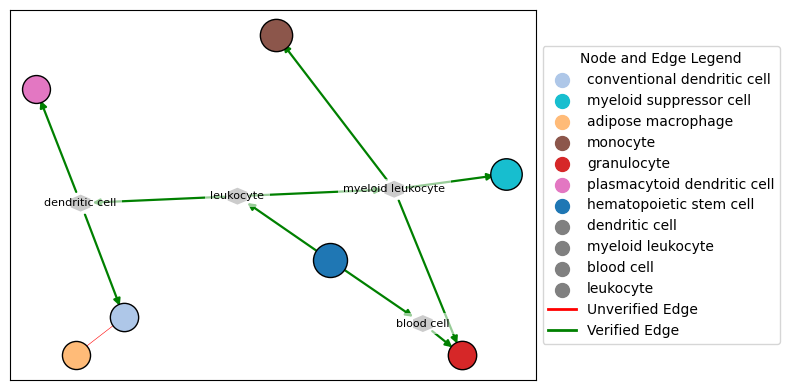

In [12]:
BRICK.pl.static_visualize_network(final_G, layout='spring', save_path="./final_G.svg")
#BRICK.pp.save_graph(final_G,"./final_G2.svg")

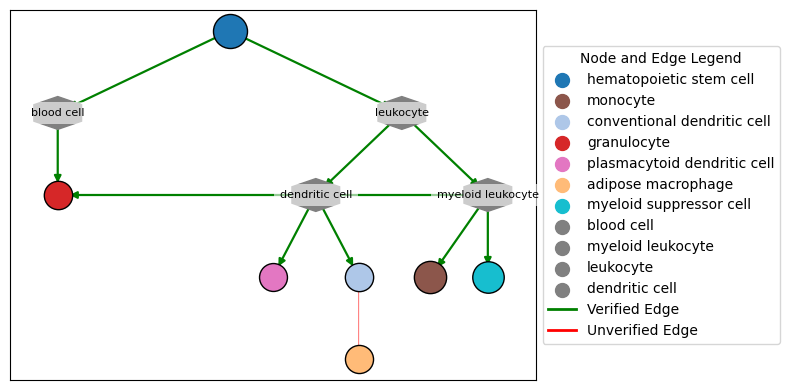

In [102]:
BRICK.pl.static_visualize_network(final_G,layout='tree')

## Interpret general cell development trajectory path
Now, we can use LLM model to interpret our general cell development trajectory

In [6]:
trajectory_graph = BRICK.pp.read_graph("./final_G_v0.svg") 
result = BRICK.inp.analyse_general_trajectory(trajectory_graph)
print("Generated Answer:", result)

Now generating answer ... 

Generated Answer: The global analysis of the cell developmental trajectory graph begins with the hematopoietic stem cell (HSC), which is the progenitor for a variety of blood cells. The green edges with arrows in the graph indicate the well-established developmental pathways supported by experimental data, while red edges represent putative pathways inferred by the PAGA algorithm. From the HSC, developmental paths lead to blood cells and leukocytes, indicating early bifurcation into distinct lineages. The transition from HSC to blood cells likely involves key regulatory genes such as GATA2 and RUNX1, which are critical for hematopoietic differentiation. 

Further down the trajectory, blood cells differentiate into granulocytes, a process that is regulated by the transcription factor CEBPA, which promotes granulocyte lineage commitment. On the leukocyte branch, we observe differentiation into myeloid leukocytes and dendritic cells. Myeloid leukocytes then fur

现在生成答案…

生成答案：细胞发育轨迹图的全局分析始于造血干细胞（HSC），它是多种血细胞的祖细胞。图中带箭头的绿色边缘表示实验数据支持的成熟发育路径，红色边缘表示PAGA算法推断的假设路径。从造血干细胞开始，发育路径通向血细胞和白细胞，表明早期分化为不同的谱系。从造血干细胞到血细胞的转变可能涉及关键调控基因，如GATA2和RUNX1，它们对造血分化至关重要。

再往下，血细胞分化为粒细胞，这一过程由转录因子CEBPA调节，该因子促进了粒细胞谱系的承诺。在白细胞分支上，我们观察到分化为髓样白细胞和树突状细胞。髓系白细胞随后进一步分化为单核细胞、髓系抑制细胞和粒细胞，这表明存在一个复杂的调控网络，涉及PU.1和IRF8等基因，已知这些基因影响髓系分化。

树突状细胞谱系分为常规树突状细胞和浆细胞样树突状细胞，IRF4和IRF8等调控基因在它们的分化中起着关键作用。值得注意的是，红色边缘表明了从传统树突状细胞到脂肪巨噬细胞的推测但未经实验证实的途径，这表明了一个潜在的新研究领域。这一假定的途径意味着可能存在其他分化途径或转分化事件，这些分化途径或转分化事件可能受外部信号或利基特异性因子的调节。

总的来说，细胞发育轨迹图描绘了一个由转录因子和信号通路网络精心策划的造血分化的良好协调和分层进展。实验数据与推断途径的整合突出了已建立的和新的潜在细胞发育途径，提供了造血细胞谱系承诺和分化的全面观点。这种复杂的基因调控和细胞信号的舞蹈强调了造血的复杂性，并邀请进一步探索PAGA推论提出的鲜为人知的途径。

## Interpret specific cell development trajectory path
We can also use LLM model to interpret one specific trajectory path

In [8]:
print("Enter source node of interest\n")
source_node = "hematopoietic stem cell"
#source_node = input()
print("Enter target node of interest\n")
target_node = "adipose macrophage"
#target_node = input()
result = BRICK.inp.analyse_specific_trajectory(trajectory_graph,source_node,target_node)
print("Generated Answer:", result)

Enter source node of interest

Enter target node of interest

Now generating answer ... 

Generated Answer: The developmental path from a hematopoietic stem cell (HSC) to an adipose macrophage can be represented as follows based on the provided trajectory paths:

1. Hematopoietic stem cell → Leukocyte (green)
2. Leukocyte → Dendritic cell (green)
3. Dendritic cell → Conventional dendritic cell (green)
4. Conventional dendritic cell → Adipose macrophage (red)

This path demonstrates a specific lineage trajectory which passes through several intermediate cell types, ultimately leading to the differentiation into an adipose macrophage. Let's analyze each step in this developmental trajectory:

### Step 1: Hematopoietic Stem Cell to Leukocyte
Hematopoietic stem cells (HSCs) are multipotent stem cells that give rise to all blood cell types through the process of hematopoiesis. HSCs first differentiate into common myeloid progenitors (CMPs) or common lymphoid progenitors (CLPs). The CMPs the

输入感兴趣的源节点

输入感兴趣的目标节点

现在生成答案…

根据所提供的轨迹路径，造血干细胞（hematopoietic stem cell， HSC）到脂肪巨噬细胞的发育路径可以表示如下：

1. 造血干细胞→白细胞（绿色）
2. 白细胞→树突状细胞（绿色）
3. 树突状细胞→常规树突状细胞（绿色）
4. 常规树突状细胞→脂肪巨噬细胞（红色）

这条路径显示了一个特定的谱系轨迹，它通过几种中间细胞类型，最终导致分化为脂肪巨噬细胞。让我们来分析一下这一发展轨迹中的每一步：

第一步：造血干细胞转化为白细胞
造血干细胞（Hematopoietic stem cells, hsc）是一种多能干细胞，通过造血过程产生所有类型的血细胞。造血干细胞首先分化为共同髓样祖细胞（CMPs）或共同淋巴样祖细胞（CLPs）。然后cmp进一步分化为各种类型的髓细胞，包括白细胞。

- **关键基因和途径**:RUNX1、GATA2、PU.1等基因在造血干细胞向髓系祖细胞分化并最终向白细胞分化的过程中起着至关重要的作用。分化还受包括JAK-STAT、Notch和Wnt信号通路在内的信号通路调节。

步骤2：白细胞转化为树突状细胞
白细胞，特别是髓系白细胞，可以进一步分化为树突状细胞（dc），这是启动和调节免疫反应所必需的。

- **关键基因和途径**：转录因子IRF8和ZBTB46在髓系祖细胞向树突状细胞分化过程中起关键作用。GM-CSF（粒细胞-巨噬细胞集落刺激因子）和FLT3L （fms样酪氨酸激酶3配体）信号通路参与了这一过程。

步骤3：树突状细胞到传统树突状细胞
树突状细胞是一种异质性细胞群，包括常规树突状细胞（cdc）和浆细胞样树突状细胞（pDCs）。传统的树突状细胞特别擅长抗原呈递，是适应性免疫反应的关键参与者。

- **关键基因和途径**：转录因子BATF3和IRF4对cdc的发展至关重要。NF-κB信号通路也在cDCs的成熟和功能中发挥作用。

步骤4：常规树突状细胞转化为脂肪巨噬细胞
脂肪巨噬细胞是一种在脂肪组织中发现的组织常驻巨噬细胞。这些细胞参与脂肪组织环境中炎症和代谢的调节。

- **关键基因和途径**：传统树突状细胞向脂肪巨噬细胞的分化涉及从免疫聚焦细胞向组织驻留巨噬细胞的转变。关键的调节因子包括转录因子C/EBPβ和PPARγ（过氧化物酶体增殖激活受体γ），它们对巨噬细胞的发育及其在脂肪组织中的功能至关重要。巨噬细胞集落刺激因子（M-CSF）信号通路对于巨噬细胞的分化和存活也是必不可少的。

# # #总结
从造血干细胞到脂肪巨噬细胞的发育轨迹涉及一系列受特定转录因子和信号通路调控的分化步骤：
HSC通过RUNX1、GATA2和PU.1分化为髓系祖细胞，受JAK-STAT、Notch和Wnt通路的影响。
-髓系祖细胞进一步分化为白细胞，然后通过IRF8和ZBTB46以及GM-CSF和FLT3L途径分化为树突状细胞。
-树突状细胞在BATF3、IRF4和NF-κ b的影响下发育为常规树突状细胞。
-最后，常规树突状细胞通过调节C/EBPβ、PPARγ和M-CSF途径转变为脂肪巨噬细胞。

这一轨迹凸显了造血分化的复杂性和特异性，它受到遗传和分子信号网络的严格控制，以确保体内不同细胞类型的正确形成和功能。